In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import decode, decode_var, get_detimage_edges, get_detimage, eff_area_vs_off_axis
from mask_utils.fits_utils import read_mask_bulk, read_fits_events
from mask_utils.image_utils import upscale, fshift

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
fits_evt = "F:/CodedMasks/Simulations/crab_cxb_2-50keV_1ks_mask_050_1040x17_cam1a_detected.fits"
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20250710.fits"

In [3]:
mask, hdmask = read_mask_bulk(mask_file, 'MASK', header_out=True, verbose=False)
rmatrix = read_mask_bulk(mask_file, 'RMATRIX', header_out=False, verbose=False)
bulk = read_mask_bulk(mask_file, 'SENS', header_out=False, verbose=False)

In [4]:
#Upscaling
ups_x=2
ups_y = 5

mask = upscale(mask, ups_y, ups_x)
rmatrix = upscale(rmatrix, ups_y, ups_x)
bulk = upscale(bulk, ups_y, ups_x)

In [5]:
#Gets mask information and define X, Y vectors (centers and edges)
ELXDIM = hdmask['ELXDIM'] / ups_x
ELYDIM = hdmask['ELYDIM'] / ups_y
ELXN   = hdmask['ELXN']  * ups_x
ELYN   = hdmask['ELYN'] * ups_y

print("Pixel dims:", ELXDIM, ELYDIM)
print("Image pixels:", ELXN, ELYN)

Pixel dims: 0.125 0.1
Image pixels: 2080 2610


In [6]:
det, hdet0, hdet1 = read_fits_events(fits_evt, header0=True, header1=True, verbose=False)
xedges, yedges = get_detimage_edges(ELXDIM, ELYDIM, ELXN, ELYN)

#Computes detector image
detimage = get_detimage(det, xedges, yedges) #* bulk

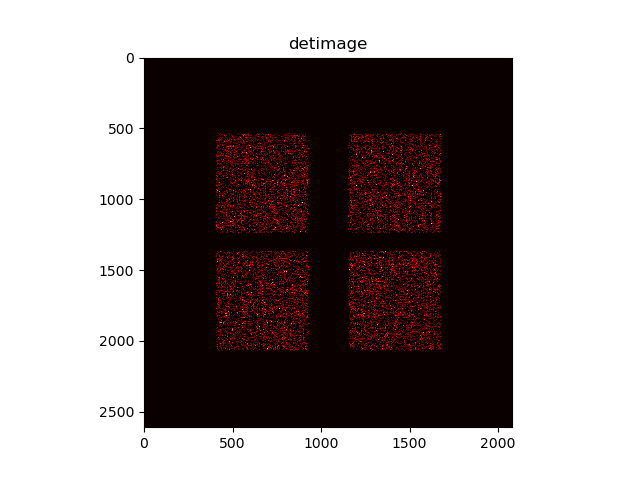

In [7]:
plt.figure()
plt.title('detimage')
plt.imshow(detimage.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

In [8]:
sky = decode(detimage, rmatrix, bulk)
peak_p = np.unravel_index(np.argmax(sky), sky.shape)

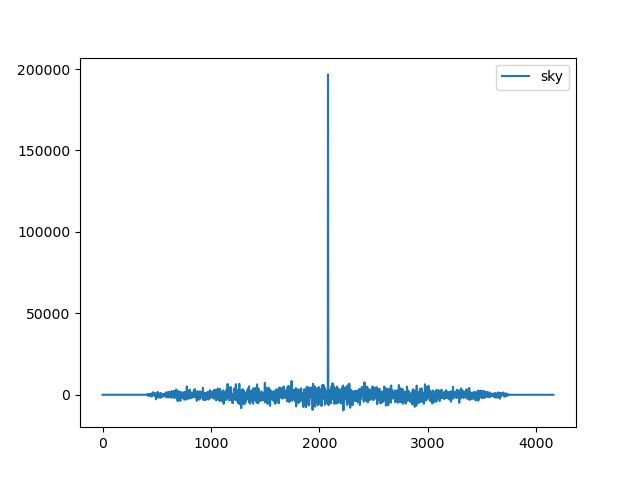

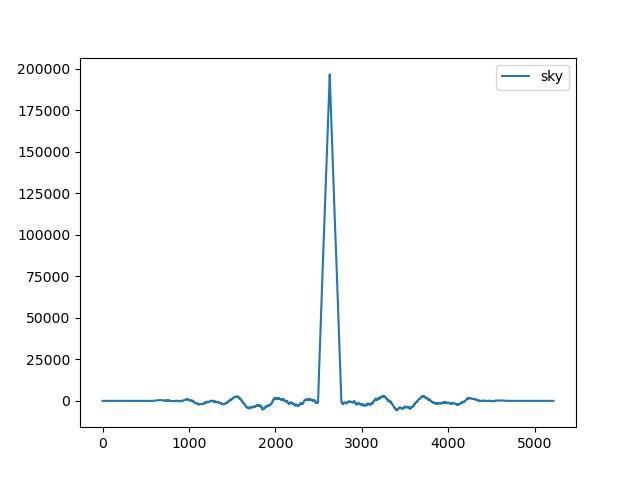

In [9]:
plt.figure()
plt.title("")
plt.plot( sky[:, peak_p[1]], label="sky")
plt.legend()

plt.figure()
plt.title("")
plt.plot( sky[peak_p[0],:], label="sky")
plt.legend()

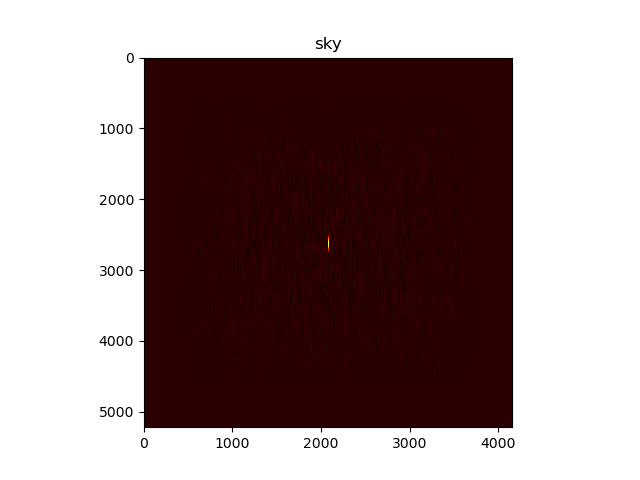

In [10]:
plt.figure()
plt.title('sky')
plt.imshow(sky.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

In [11]:
var_bal = decode_var(detimage, rmatrix, bulk, 202.9, ELXDIM, ELYDIM)
var_bal_clipped =  np.clip(var_bal, a_min=1E-8, a_max=np.sum(detimage)) if np.any(var_bal <= 0) else var_bal

skysign = sky/np.sqrt(var_bal_clipped)

# Filtering borders...
skysign_cut = skysign[205*ups_x:-205*ups_x, 134*ups_y:-134*ups_y ]
s_counts = np.max(sky)
bkg_counts = np.sum(detimage) - np.max(sky)
print("Source counts", s_counts)
print("Bkg counts", bkg_counts)
print("Total counts", s_counts + bkg_counts)
effarea_x = 0.01 * eff_area_vs_off_axis(mask.T.astype('int32'), bulk.T, ELXDIM, ELYDIM, 202.9, 0.150, 0, 0, degrees=True)

print("Src counts/cm2/s:", s_counts/1000/effarea_x)
print("Bkg counts/cm2/s:", bkg_counts/1000/effarea_x)



Source counts 196691.84977402163
Bkg counts 487584.15022597834
Total counts 684276.0
Src counts/cm2/s: 2.5736584857575613
Bkg counts/cm2/s: 6.379903830238513


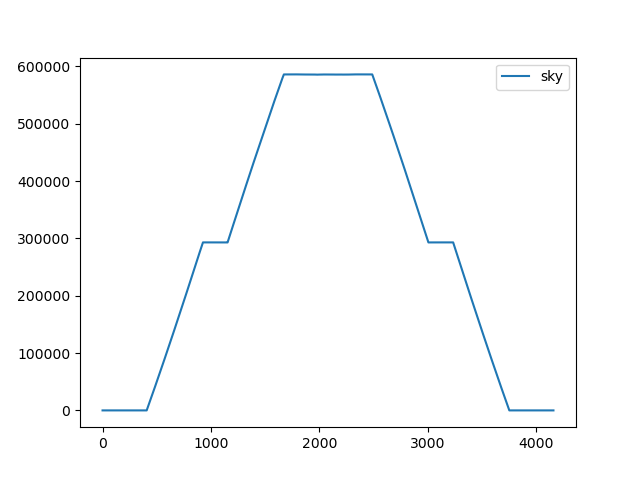

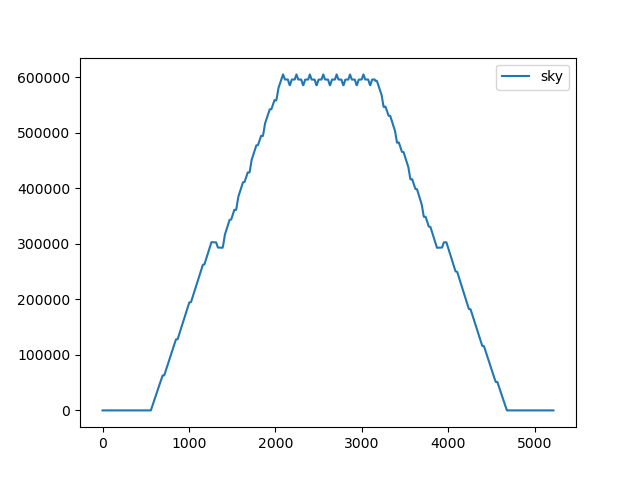

In [12]:
plt.figure()
plt.title("")
plt.plot( var_bal[:, peak_p[1]], label="sky")
plt.legend()
plt.show()

plt.figure()
plt.title("")
plt.plot( var_bal[peak_p[0],:], label="sky")
plt.legend()
plt.show()

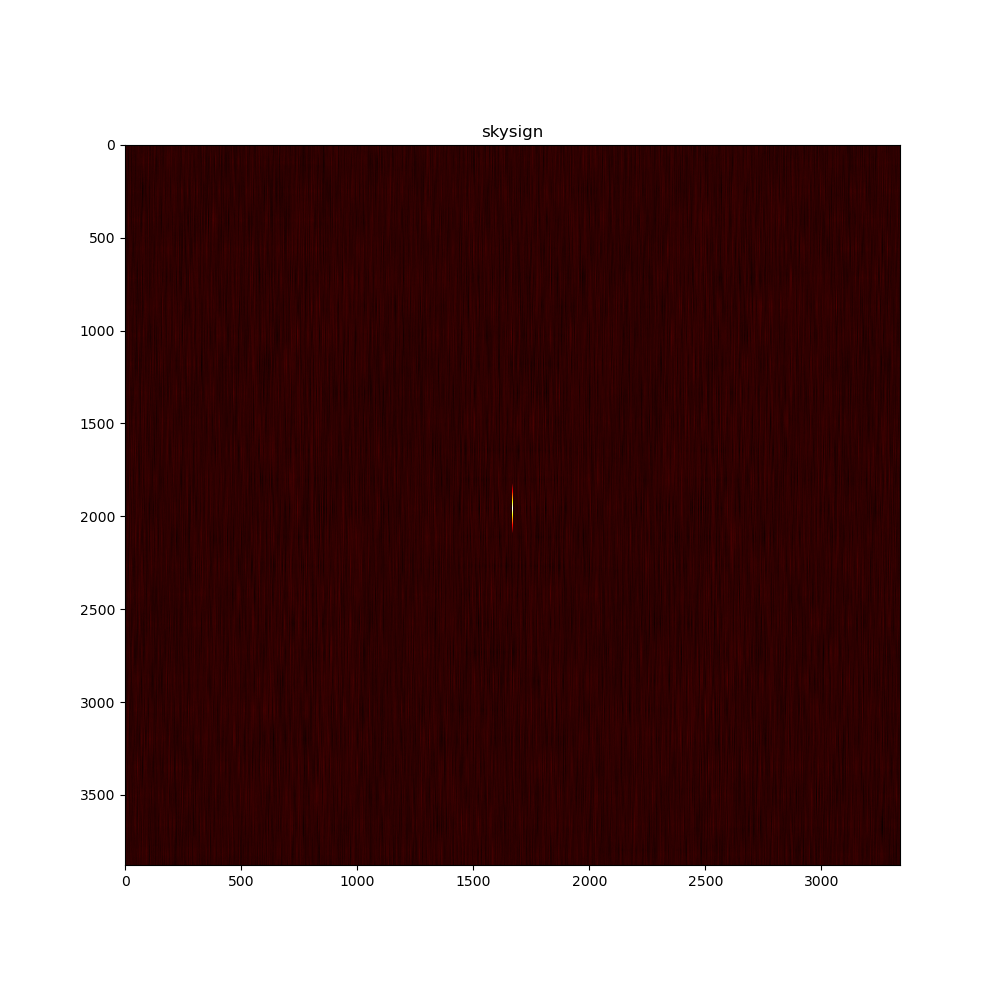

In [18]:
plt.figure(figsize=(10, 10))
plt.title('skysign')
plt.imshow(skysign_cut.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

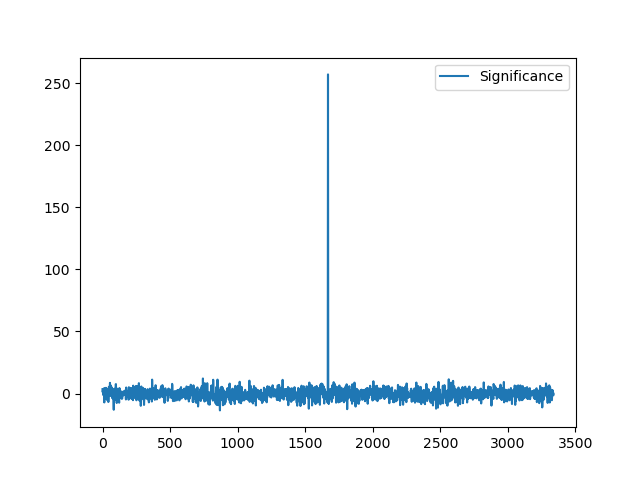

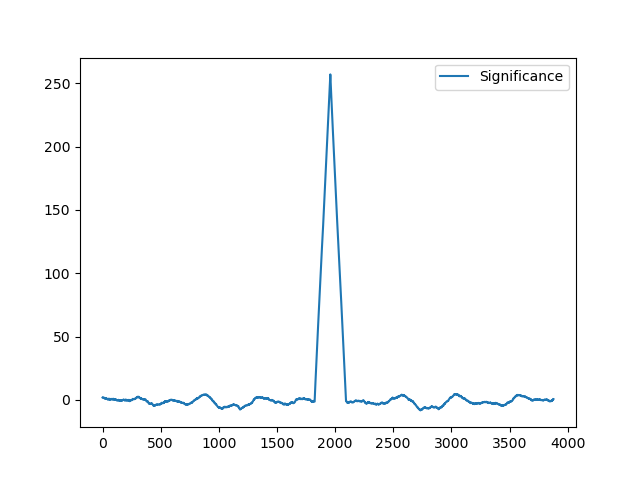

In [14]:
peak_s = np.unravel_index(np.argmax(skysign_cut), skysign_cut.shape)

plt.figure()
plt.title("")
plt.plot( skysign_cut[:, peak_s[1]], label="Significance")
plt.legend()
plt.show()
plt.figure()
plt.title("")
plt.plot( skysign_cut[peak_s[0],:], label="Significance")
plt.legend()
plt.show()

In [15]:
print("Peak significance:", np.max(skysign_cut))

Peak significance: 256.9311704361358


[ 5.59654377e+05 -3.92152347e-02  2.48051474e+00]


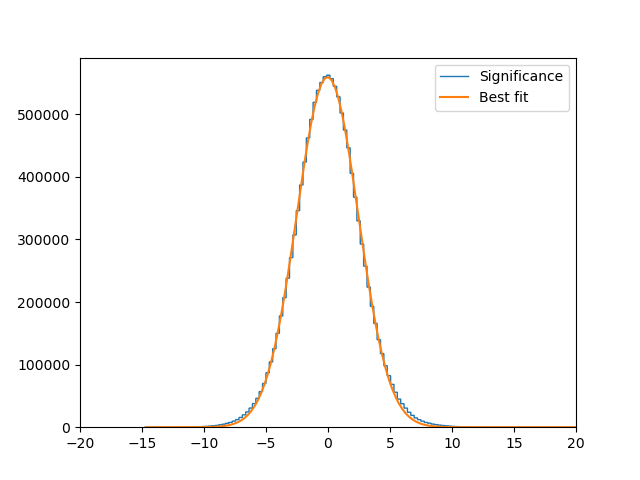

In [16]:
hsign, bins = np.histogram(skysign_cut, bins=1000,  density=False)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

from scipy.optimize import curve_fit
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt, _ = curve_fit(gauss, xdata=binscenters, ydata=hsign, p0=[1, 0, 1.0])
fitted = gauss(binscenters, *popt)
print(popt)

plt.figure()
plt.title("")
plt.stairs(hsign, bins, label="Significance")
plt.plot(binscenters, fitted, label="Best fit")
plt.xlim(-20, 20)
plt.legend()
plt.show()
